**MODEL TRAINING**

In [ ]:
!pip install datasets

In [ ]:
# === Core Python ===
import os
import re
import ast
import random
import numpy as np
import pandas as pd
import torch
import logging
import tempfile
from pathlib import Path
from functools import lru_cache

# === Visualization ===
import matplotlib.pyplot as plt
import seaborn as sns

# === NLP / Transformers ===
from transformers import (
    pipeline,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
)

# === Sklearn ===
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

# === Audio Processing ===
import speech_recognition as sr
from pydub import AudioSegment

# === Image Processing ===
from PIL import Image
import pytesseract

# === HuggingFace Datasets ===
from datasets import Dataset

# === Streamlit ===
import streamlit as st


In [1]:


# Disable Weights and Biases
os.environ["WANDB_DISABLED"] = "true"

# 1. Load and preprocess the dataset
df = pd.read_csv("goodreads_data.csv", engine="python", on_bad_lines="skip")

# Clean Num_Ratings if present
if "Num_Ratings" in df.columns:
    df["Num_Ratings"] = df["Num_Ratings"].astype(str).str.replace(",", "").astype(float)

# Clean Description
df["Description"] = df["Description"].fillna("").astype(str).apply(lambda x: re.sub(r"\s+", " ", x.strip()))
df = df[df["Description"].str.split().apply(len) > 20]

# Clean Genre
def clean_genre(x):
    try:
        genres = ast.literal_eval(x)
        return genres[0].strip() if isinstance(genres, list) else str(x).strip()
    except:
        return str(x).strip()

df["Primary_Genre"] = df["Genres"].replace(r'^\s*$', 'Unknown', regex=True).fillna("Unknown").apply(clean_genre)

# Remove rare genres
genre_counts = df["Primary_Genre"].value_counts()
valid_genres = genre_counts[genre_counts >= 50].index
df = df[df["Primary_Genre"].isin(valid_genres)]

# Sample up to 2000 per genre (balanced sampling)
n_samples_per_genre = 2000
df = df.groupby('Primary_Genre').apply(
    lambda x: x.sample(n=min(len(x), n_samples_per_genre), random_state=42)
).reset_index(drop=True)

# Encode labels
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["Primary_Genre"])
label_map = {index: label for index, label in enumerate(label_encoder.classes_)}

# Combine Title + Description
df["Book"] = df["Book"].fillna("")
df["text"] = df["Book"] + " " + df["Description"]

# TF-IDF based outlier removal
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(df["text"])
tfidf_norms = np.linalg.norm(X_tfidf.toarray(), axis=1)
df["tfidf_norm"] = tfidf_norms
df = df[df["tfidf_norm"] < np.percentile(tfidf_norms, 95)]

# Final dataset
df = df[["text", "label"]]

# Stratified Train/Val/Test split
train_text, temp_text, train_labels, temp_labels = train_test_split(
    df['text'], df['label'], test_size=0.1, random_state=42, stratify=df['label']
)

val_text, test_text, val_labels, test_labels = train_test_split(
    temp_text, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
)

train_df = pd.DataFrame({'text': train_text, 'label': train_labels})
val_df = pd.DataFrame({'text': val_text, 'label': val_labels})
test_df = pd.DataFrame({'text': test_text, 'label': test_labels})


# Tokenization and Dataset Preparation
model_name = "roberta-large"  # more powerful model
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(batch["text"], padding='max_length', truncation=True, max_length=256)

train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset = val_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

# Change the format to numpy first
train_dataset.set_format("numpy", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format("numpy", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format("numpy", columns=["input_ids", "attention_mask", "label"])

# Manually convert numpy arrays to torch tensors
def numpy_to_torch(batch):
    return {k: torch.tensor(v) for k, v in batch.items()}

train_dataset.set_transform(numpy_to_torch)
val_dataset.set_transform(numpy_to_torch)
test_dataset.set_transform(numpy_to_torch)


# Load model and define training arguments
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_map))

training_args = TrainingArguments(
    output_dir="./best_model",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=8,
    weight_decay=0.01,
    warmup_steps=500,
    logging_dir="./logs",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_accuracy",
    greater_is_better=True,
    seed=42,
    label_smoothing_factor=0.1,
    fp16=torch.cuda.is_available()
)

# Evaluation metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="weighted")
    return {"accuracy": acc, "f1": f1}

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer.train()

# Save the model
model.config.label2id = {v: k for k, v in label_map.items()}
model.config.id2label = label_map
model.save_pretrained("./best_model")
tokenizer.save_pretrained("./best_model")

# Final evaluation
test_results = trainer.evaluate(test_dataset)
print("\nTest set results:")
print(f"Accuracy: {test_results['eval_accuracy']:.4f}")
print(f"F1 Score: {test_results['eval_f1']:.4f}")

print("✅ Model training complete and saved.")


/tmp/ipython-input-2505786764.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Primary_Genre').apply(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/7100 [00:00<?, ? examples/s]

Map:   0%|          | 0/394 [00:00<?, ? examples/s]

Map:   0%|          | 0/395 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,1.741231,0.614213,0.584809
2,2.334000,1.541431,0.634518,0.623871
3,1.478200,1.641456,0.642132,0.630199
4,1.122700,1.634826,0.677665,0.670338
5,0.893400,1.682847,0.677665,0.669592
6,0.774000,1.845017,0.675127,0.661851



Test set results:
Accuracy: 0.6911
F1 Score: 0.6875
✅ Model training complete and saved.


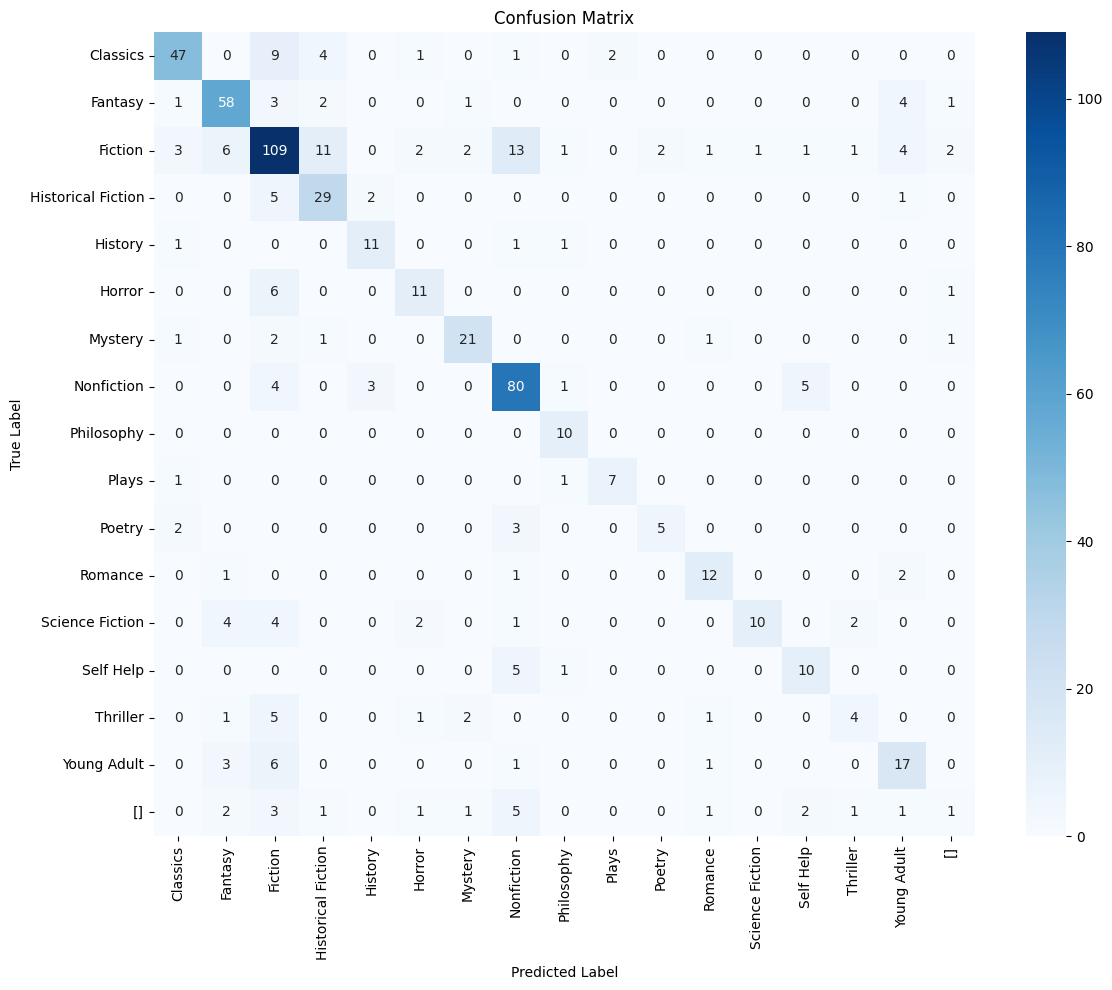

In [ ]:

# Get test predictions
predictions = trainer.predict(test_dataset)
y_true = predictions.label_ids
y_pred = predictions.predictions.argmax(-1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
labels = [label_map[i] for i in range(len(label_map))]

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

**FOR BOOK DESCRIPTION**

In [ ]:

# ===  Load model and tokenizer for inference ===
model_path = "./best_model"
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Create pipeline
pipeline = pipeline("text-classification", model=model, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1)

# ===  Prediction loop ===
print("📚 Book Genre Prediction System (Type 'exit' to quit)")
while True:
    user_input = input("\nEnter book description or review: ")
    if user_input.lower() == "exit":
        print("Goodbye! 📖")
        break

    if len(user_input.strip().split()) < 5:
        print("⚠  Please enter a longer description for accurate prediction.")
        continue

    # Make prediction
    prediction = pipeline(user_input, truncation=True, max_length=512)[0]
    predicted_genre = prediction["label"]  # Automatically returns genre if id2label is set

    print(f"\n📖 Input: {user_input}")
    print(f"🔮 Predicted Genre: {predicted_genre}")
    print(f"📊 Confidence Score: {prediction['score']:.2f}")


Device set to use cuda:0


📚 Book Genre Prediction System (Type 'exit' to quit)

Enter book description or review: exit
Goodbye! 📖


**VOICE/TEXT/IMAGE**

In [ ]:


# ========== SETTINGS ==========
MODEL_PATH = "./best_model"
EMOTION_MODEL = "j-hartmann/emotion-english-distilroberta-base"

# ========== EMOTION TO GENRE MAP ==========
emotion_to_genre = {
    "joy": "Comedy, Romance",
    "sadness": "Romance, Drama",
    "anger": "Thriller, Mystery",
    "fear": "Fantasy, Paranormal",
    "disgust": "Dark Fiction, Horror",
    "surprise": "Adventure, Sci-Fi",
    "neutral": "Contemporary Fiction",
    "love": "Romance, Fantasy Romance",
    "curiosity": "Historical Fiction, Sci-Fi",
    "guilt": "Psychological Fiction, Thriller",
    "shame": "Drama, Tragedy",
    "pride": "Self-help, Motivational",
    "hope": "Inspiration, Self-help",
    "relief": "Feel-good, Contemporary Fiction",
    "confusion": "Psychological Thriller, Mystery",
    "excitement": "Adventure, Fantasy"
}

# ========== LOAD MODELS ==========
genre_model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)
genre_tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
genre_pipeline = pipeline("text-classification", model=genre_model, tokenizer=genre_tokenizer, device=0 if torch.cuda.is_available() else -1)
emotion_pipeline = pipeline("text-classification", model=EMOTION_MODEL, return_all_scores=True)

# ========== OCR FUNCTION ==========
def ocr_image(image_path):
    try:
        img = Image.open(image_path)
        text = pytesseract.image_to_string(img)
        print(f"\n🖼️ Extracted Text from Image:\n{text.strip()}\n")
        return text.strip()
    except Exception as e:
        print(f"⚠️ Error reading image: {e}")
        return ""

# ========== VOICE FUNCTION ==========
def get_audio_input_from_file(file_path):
    recognizer = sr.Recognizer()

    if not file_path.endswith(".wav"):
        audio = AudioSegment.from_file(file_path)
        audio = audio.set_channels(1).set_frame_rate(16000)
        wav_path = "/tmp/temp_audio.wav"
        audio.export(wav_path, format="wav")
        file_path = wav_path

    with sr.AudioFile(file_path) as source:
        audio_data = recognizer.record(source)

    try:
        text = recognizer.recognize_google(audio_data)
        print(f"📢 Recognized Speech: {text}")
        return text
    except sr.UnknownValueError:
        print("⚠ Could not understand the audio.")
        return None
    except sr.RequestError:
        print("⚠ Could not request results from Google Speech Recognition.")
        return None

# ========== TEXT GENRE/EMOTION PREDICTION ==========
def predict_from_text(user_input):
    mood_keywords = [
        "i feel", "i'm", "i am", "feeling", "bored", "sad", "happy",
        "angry", "depressed", "anxious", "lonely", "tired", "stressed",
        "guilty", "shame", "proud", "hopeful", "relieved", "excited", "confused"
    ]

    if len(user_input.split()) < 8 or any(kw in user_input.lower() for kw in mood_keywords):
        emotions = emotion_pipeline(user_input, truncation=True, max_length=128)[0]
        detected_emotions = [(emotion['label'].lower(), emotion['score']) for emotion in emotions]
        sorted_emotions = sorted(detected_emotions, key=lambda x: x[1], reverse=True)
        top_emotions = [emotion for emotion, score in sorted_emotions[:3]]
        combined_genres = set()
        for emotion in top_emotions:
            genre = emotion_to_genre.get(emotion, "General Fiction")
            combined_genres.update(genre.split(", "))
        genre_suggestion = ", ".join(combined_genres)

        print(f"\n🧠 Detected Moods: {', '.join(top_emotions).capitalize()}")
        print(f"📖 Suggested Book Genres: {genre_suggestion}")
    else:
        prediction = genre_pipeline(user_input, truncation=True, max_length=512)[0]
        predicted_genre = prediction["label"]
        print(f"\n📖 Input: {user_input}")
        print(f"🔮 Predicted Genre: {predicted_genre}")
        print(f"📊 Confidence Score: {prediction['score']:.2f}")

# ========== MAIN LOOP ==========
def main():
    print("📚 Book Genre Prediction System")
    print("Type 'exit' to quit.")
    print("Type 'image' to upload a book synopsis image.")
    print("Type 'voice' to upload a voice file (.wav/.mp3) for prediction.")

    while True:
        user_input = input("\nEnter book description, mood, 'image', or 'voice': ").strip()

        if user_input.lower() == "exit":
            print("Goodbye! 📖")
            break
        elif user_input.lower() == "image":
            image_path = input("Enter the path to the book synopsis image: ").strip()
            if not os.path.isfile(image_path):
                print("⚠️ File not found. Please try again.")
                continue
            extracted_text = ocr_image(image_path)
            if extracted_text:
                predict_from_text(extracted_text)
        elif user_input.lower() == "voice":
            audio_path = input("Enter the path to your audio file: ").strip()
            if not os.path.isfile(audio_path):
                print("⚠️ File not found. Please try again.")
                continue
            transcribed_text = get_audio_input_from_file(audio_path)
            if transcribed_text:
                predict_from_text(transcribed_text)
        else:
            predict_from_text(user_input)

if __name__ == "__main__":
    main()


Device set to use cuda:0
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/294 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/329M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cuda:0
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


📚 Book Genre Prediction System
Type 'exit' to quit.
Type 'image' to upload a book synopsis image.
Type 'voice' to upload a voice file (.wav/.mp3) for prediction.

Enter book description, mood, 'image', or 'voice': exit
Goodbye! 📖


In [ ]:
!pip install pytesseract

In [ ]:
!pip install SpeechRecognition
!pip install transformers
!pip install torch
!pip install pydub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.9/32.9 MB 66.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 64.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

**DASHBOARD**

In [2]:
!pip install streamlit pyngrok transformers datasets torch torchvision torchaudio pytesseract SpeechRecognition pydub


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 97.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 827.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 866.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
!pkill -f ngrok

In [2]:
!ngrok config add-authtoken 2wfgCH3dyPyzAi3WeW5xl0cGw2N_6Dwk3uzRre4AjgqCZKq2m


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [7]:
%%writefile app.py

# ----------------- Basic config & logging -----------------
logging.basicConfig(level=logging.INFO)
LOG = logging.getLogger("feel2read")

# Make paths portable
ROOT = Path.cwd()
MODEL_PATH = ROOT / "best_model"
EMOTION_MODEL = "j-hartmann/emotion-english-distilroberta-base"

# ----------------- Reproducibility -----------------
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# ----------------- Page Setup -----------------
st.set_page_config(page_title="📚 Feel2Read", layout="centered")

st.markdown(
    """
    <style>
    body {
        background-image: url("https://images.unsplash.com/photo-1512820790803-83ca734da794");
        background-size: cover;
        background-repeat: no-repeat;
        background-attachment: fixed;
    }
    .stApp {
        background-color: rgba(255, 255, 255, 0.85);
        padding: 2rem;
        border-radius: 12px;
        max-width: 800px;
        margin: auto;
    }
    .css-1cpxqw2 {
        color: black;
    }
    </style>
    """,
    unsafe_allow_html=True
)

# ----------------- Emotion -> Genre mapping -----------------
emotion_to_genre = {
    "joy": "Comedy, Romance",
    "sadness": "Romance, Drama",
    "anger": "Thriller, Mystery",
    "fear": "Fantasy, Paranormal",
    "disgust": "Dark Fiction, Horror",
    "surprise": "Adventure, Sci-Fi",
    "neutral": "Contemporary Fiction",
    "love": "Romance, Fantasy Romance",
    "curiosity": "Historical Fiction, Sci-Fi",
    "guilt": "Psychological Fiction, Thriller",
    "shame": "Drama, Tragedy",
    "pride": "Self-help, Motivational",
    "hope": "Inspiration, Self-help",
    "relief": "Feel-good, Contemporary Fiction",
    "confusion": "Psychological Thriller, Mystery",
    "excitement": "Adventure, Fantasy"
}

# ----------------- Device -----------------
DEVICE = 0 if torch.cuda.is_available() else -1  # for Hugging Face pipeline: 0 -> GPU, -1 -> CPU

# ----------------- Cached loaders -----------------
@st.cache_resource(show_spinner=True)
def load_genre_pipeline(model_path: str):
    """Load and cache the genre model + pipeline for Streamlit usage."""
    try:
        tokenizer = AutoTokenizer.from_pretrained(model_path)
        model = AutoModelForSequenceClassification.from_pretrained(model_path)
        model.eval()
        pl = pipeline("text-classification", model=model, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1)
        return pl
    except Exception as e:
        LOG.exception("Failed to load genre pipeline: %s", e)
        raise

@st.cache_resource(show_spinner=True)
def load_emotion_pipeline(model_name: str):
    """Load and cache the emotion classification pipeline."""
    try:
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForSequenceClassification.from_pretrained(model_name)
        model.eval()
        pl = pipeline("text-classification", model=model, tokenizer=tokenizer, return_all_scores=True, device=0 if torch.cuda.is_available() else -1)
        return pl
    except Exception as e:
        LOG.exception("Failed to load emotion pipeline: %s", e)
        raise

# Load pipelines (cached)
try:
    genre_pipeline = load_genre_pipeline(str(MODEL_PATH))
except Exception as e:
    st.error("Could not load genre model. Check logs.")
    raise

try:
    emotion_pipeline = load_emotion_pipeline(EMOTION_MODEL)
except Exception as e:
    st.error("Could not load emotion model. Check logs.")
    raise

# ----------------- Utilities -----------------
def safe_predict_genre_from_pipeline(text: str):
    try:
        prediction = genre_pipeline(text, truncation=True, max_length=512)
        if not prediction or not prediction[0].get("label"):
            return "General Fiction"
        return prediction[0]["label"]
    except Exception as e:
        LOG.exception("Genre prediction failed: %s", e)
        return "General Fiction"

def safe_predict_emotion_and_map(text: str, top_k: int = 1):
    """Return top emotion labels (lowercase) and mapped genres."""
    try:
        scores = emotion_pipeline(text, truncation=True, max_length=128)[0]
        sorted_emotions = sorted(scores, key=lambda x: x["score"], reverse=True)
        top_emotions = [e["label"].lower() for e in sorted_emotions[:top_k]]
        combined_genres = set()
        for emo in top_emotions:
            combined_genres.update(emotion_to_genre.get(emo, "General Fiction").split(", "))
        if not combined_genres:
            return top_emotions, ["General Fiction"]
        return top_emotions, list(combined_genres)
    except Exception as e:
        LOG.exception("Emotion prediction failed: %s", e)
        return [], ["General Fiction"]

def predict_from_text(user_input: str):
    try:
        mood_keywords = [
            "i feel", "i'm", "i am", "feeling", "bored", "sad", "happy",
            "angry", "depressed", "anxious", "lonely", "tired", "stressed",
            "guilty", "shame", "proud", "hopeful", "relieved", "excited", "confused"
        ]

        if len(user_input.split()) < 8 or any(kw in user_input.lower() for kw in mood_keywords):
            top_emotions, genres = safe_predict_emotion_and_map(user_input, top_k=1)
            if not genres:
                return "Based on emotion:", "General Fiction"
            return f"Based on emotion ({', '.join(top_emotions)}):", ', '.join(genres)
        else:
            predicted_label = safe_predict_genre_from_pipeline(user_input)
            return "Predicted Genre:", predicted_label
    except Exception as e:
        LOG.exception("predict_from_text failed: %s", e)
        return "❌ Please enter valid information.", None

def transcribe_audio(uploaded_file):
    """Transcribe audio using pydub + SpeechRecognition (Google). Returns recognized text or None."""
    try:
        recognizer = sr.Recognizer()
        audio = AudioSegment.from_file(uploaded_file)
        audio = audio.set_channels(1).set_frame_rate(16000)
        # Use a portable temporary file
        with tempfile.NamedTemporaryFile(suffix=".wav", delete=True) as tmp:
            audio.export(tmp.name, format="wav")
            with sr.AudioFile(tmp.name) as source:
                audio_data = recognizer.record(source)
            return recognizer.recognize_google(audio_data)
    except sr.UnknownValueError:
        LOG.warning("SpeechRecognition could not understand audio")
        return None
    except Exception as e:
        LOG.exception("Audio transcription failed: %s", e)
        return None

def extract_text_from_image(img_file):
    try:
        img = Image.open(img_file)
        return pytesseract.image_to_string(img).strip()
    except Exception as e:
        LOG.exception("Image OCR failed: %s", e)
        return None

# ----------------- Streamlit UI -----------------
st.markdown("<h1 style='text-align: center;'>📚FEEL2READ Welcomes You </h1>", unsafe_allow_html=True)
st.markdown("### Choose your input method:")

option = st.radio("Input Type", ["📝 Text", "🖼️ Image", "🎙️ Voice"])

if option == "📝 Text":
    st.markdown("#### ✍️ You can either enter a mood or book description.")
    mood_list = ["joy", "sadness", "anger", "fear", "disgust", "surprise", "neutral", "love",
                 "curiosity", "guilt", "shame", "pride", "hope", "relief", "confusion", "excitement"]

    mood_emojis = {
        "joy": "😊", "sadness": "😢", "anger": "😠", "fear": "😨", "disgust": "🤢", "surprise": "😲",
        "neutral": "😐", "love": "❤️", "curiosity": "🤔", "guilt": "😓", "shame": "😳", "pride": "😌",
        "hope": "🌟", "relief": "😌", "confusion": "😕", "excitement": "🤩"
    }
    mood_options = [f"{mood_emojis[m]} {m}" for m in mood_list]

    selected_mood = st.selectbox("😄 Or pick a mood directly:", [""] + mood_options)
    user_input = st.text_area("🧠 Or write something in your own words:")

    if st.button("🔍 Predict Genre"):
        final_input = user_input
        if selected_mood and not user_input.strip():
            mood_only = selected_mood.split(" ", 1)[1].strip().lower()
            genre = emotion_to_genre.get(mood_only, "General Fiction")
            st.success(f"Based on mood:")
            st.markdown(f"**{genre}**")
        elif final_input.strip():
            label, genre = predict_from_text(final_input)
            if genre:
                st.success(label)
                st.markdown(f"**{genre}**")
            else:
                st.error(label)
        else:
            st.warning("Please enter a mood or some text.")

elif option == "🖼️ Image":
    st.markdown("#### 📸 Upload an image of a book cover or description.")
    img_file = st.file_uploader("Upload Image", type=["png", "jpg", "jpeg"])
    if st.button("🔍 Predict from Image") and img_file:
        text = extract_text_from_image(img_file)
        if text:
            st.info(f"📝 Extracted Text:\n{text}")
            label, genre = predict_from_text(text)
            if genre:
                st.success(label)
                st.markdown(f"**{genre}**")
            else:
                st.error(label)
        else:
            st.error("❌ Could not extract text from the image. Try a clearer photo.")

elif option == "🎙️ Voice":
    st.markdown("#### 🎤 Upload a short audio file with your description or mood.")
    audio_file = st.file_uploader("Upload Audio", type=["wav", "mp3", "m4a"])
    if st.button("🔍 Predict from Voice") and audio_file:
        text = transcribe_audio(audio_file)
        if text:
            st.info(f"📝 Transcribed Text:\n{text}")
            label, genre = predict_from_text(text)
            if genre:
                st.success(label)
                st.markdown(f"**{genre}**")
            else:
                st.error(label)
        else:
            st.error("❌ Could not transcribe the audio. Please try a clearer recording.")


Overwriting app.py


In [8]:
!streamlit run app.py &>/content/log.txt &

In [9]:
!tail -n 20 /content/log.txt




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8502
  Network URL: http://172.28.0.12:8502
  External URL: http://34.187.132.20:8502



In [10]:
from pyngrok import ngrok

# Ensure you are specifying the correct port
public_url = ngrok.connect(8501)  # Assuming your Streamlit app is running on port 8501
print("Streamlit URL:", public_url)


Streamlit URL: NgrokTunnel: "https://71eb4ba0e76f.ngrok-free.app" -> "http://localhost:8501"
